# Few Useful Things To Know About Machine Learning

Recently I read [Peter Domingos](https://homes.cs.washington.edu/~pedrod/) [paper](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) on few useful things about Machine Learning, which discusses lessons learnt by Machine Learning researchers. 

This is an attempt to understand, summarize and implement the ideas mentioned in the paper by taking up suitable examples wherever possible.

## Table Of Content

* [Introduction](#introduction)
* [Learning=Representation+Evaluation+Optimization](#learning)
* [It's Generalization that counts !](#generalization)
* [Data Alone is not enough](#data)
* [Overfitting has many faces](#overfitting)
* [Intuition fails in high dimensions](#intuition)
* [Theoretical Gurantees are not what they seem](#theoretical)
* [Feature Engineering is key](#feature)
* [More data beats a cleverer algorithm](#more-data)
* [Learn many models not just one](#many-models)
* [Simplicity does not imply accuracy](#simplicity)
* [Representable does not imply learnable](#representable)
* [Correlation does not imply causation](#correlation-causation)
* [Conclusion](#conclusion)

In [466]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

from functools import reduce

import warnings
warnings.filterwarnings('ignore')

SEED = 1932
np.random.seed(SEED)

## Introduction <a class="anchor" id="introduction"></a>

Machine Learning algorithms can learn to perform variety of tasks just generalizing from examples which has made them very important tools in Computer Science and various other fields. To apply machine learning successfully on a particular task there are few concepts and pitfalls one should be aware of. The goal is to explain these concepts and pitfalls in detail.

Throughout this notebook we plan to explain these concepts by taking the example of ** classification ** which is a very matured example of machine learning. We would first give an example of classification and explain all the terms revolving it.

Example of classification is a ** spam filter ** which classifies emails into _spam_ and _not spam_.

__Input__  :  Email message (Boolean vector $ x = (x_1, . . . , x_j , . . . , x_d),where , x_j = 1 $
if the jth word in the dictionary appears in the email and
$x_j = 0$ otherwise

__Output__ : Label ( whether it is spam or not )

__Example__: Pair of input and output ( Input, Label )

__Classifier__: Takes input and outputs single discrete value ( label ) 

__Learner__: Takes training examples and outputs a classifier

Test of this learner is whether the classifier found is able to predict correct label for unseen emails or not.

## Learning = Representation + Evaluation + Optimization. <a class="anchor" id="learning"></a>

Suppose we have a problem and we feel that we could develop a ML solution for it, the first problem we face is to pick out an algorithm from large list of ML algorithms out there. This huge list is made up of three important components:

- Representation
    - Classifier has to be represented in a way that is computer understandable.
    - Choosing a representation is tantamount to set of classifiers that could be learnt.
    - e.g.: Instance based methods use a representation where we assume that nearby examples in our dataset are similar in terms of labels.
    - This set of classifiers constitute hypothesis space.
    - If a classifier is not in the hypothesis space it can't be learnt.
    

- Evaluation Function
    - is needed to distinguish _good_ from _bad_ classifiers.
    - evaluation function used internally may be well different from the one we want classifier to optimize.
    - e.g. We could train a linear model which uses [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) as internal evaluation function for training but we may want to optimize for accuracy, so we would choose a classifier that would give us highest accuracy without worrying about the internal metric.


- Optimization
    - Finally we need to search through this set of classifiers for the one with the highest score.
    - The choice of optimizer governs the kind of classifiers learnt if the evaluation function has more than single optimum.
    
    
Let's take an example of binary-classification where we will be using a synthetic dataset and implementing the notion of a __learner__ which takes training examples as input and outputs a classifier.

Our dataset has two features and a target variable ( that we want to predict for future examples ). Goal is to understand how a learner finds out a classifier from hypothesis space. For this dataset we will be using [Nearest Neighbor Classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to demonstrate the idea.

In [374]:
def plot(X, y):
    fig, ax = plt.subplots(1, figsize=(10, 6))
    ymap    = {'r': 0, 'b': 1}
    lmap    = {'r': 'neg', 'b': 'pos'}
    
    for c in ['r', 'b']:
        mask = ( y == ymap[c] )
        plt.scatter(X[mask, 0], X[mask, 1], c=c, label=lmap[c], alpha=.5, edgecolor='none')
    
    plt.xlabel('First Feature')
    plt.ylabel('Second Feature')
    plt.legend();

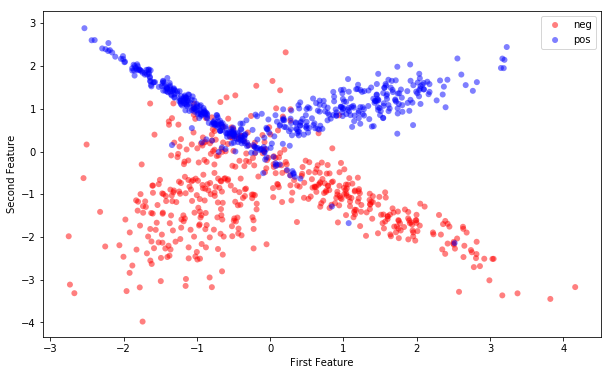

In [375]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, random_state=SEED)
plot(X, y)

Red labels represent examples of class 0 and blue represent examples of class 1.

In [378]:
class InstanceLearner(object):
    def __init__(self, X, y, eval_func):
        self.X = X
        self.y = y
        self.eval_func = eval_func
        self.score = -np.inf
        
    def init_classifier(self):
        return KNeighborsClassifier(n_jobs=-1)
    
    def evaluate(self, classifier):
        classifier.fit(scale(self.X), y)
        yhat = classifier.predict(scale(self.X))
        return self.eval_func(self.y, yhat)
    
    def get_classifiers(self, space):
        classifiers = []
        
        for k in space.keys():
            for v in space[k]:
                classifier = self.init_classifier()
                classifier.set_params(**{k:v})
                
                classifiers.append(classifier)
                
        return classifiers
    
    def optimize(self):
        space            = {'n_neighbors': [1, 3, 5]}
        self.classifiers = self.get_classifiers(space)
        self.scores      = []
            
        for classifier in self.classifiers:
            mscore = self.evaluate(classifier)
            self.scores.append(mscore)
            
            if mscore > self.score:
                self.opt_classifier, self.score = classifier, mscore
                
        return self.opt_classifier, self.score
    
    def show(self):
        for index, classifier in enumerate(self.classifiers):
            print('Classifier : {}'.format(classifier))
            print('Score      : {}'.format(self.scores[index]))
            print('*' * 100)
            print()

In [379]:
learner = InstanceLearner(X, y, accuracy_score)
optimal_classifier, best_score = learner.optimize()
learner.show()

Classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')
Score      : 1.0
****************************************************************************************************

Classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')
Score      : 0.944
****************************************************************************************************

Classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
Score      : 0.927
****************************************************************************************************



In [380]:
print('Best classifier : {}'.format(optimal_classifier))
print('Best score: {}'.format(best_score))

Best classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')
Best score: 1.0


We gave a search space to our learner i.e `{n_neighbors: [1, 3, 5}` and evaluation function as `accuracy` which means it would consider nearest neighbor classifiers that take into account nearest ( 1, 3 and 5 ) neighbors and out of those find the one with the highest accuracy score.


|Representation|Evaluation|Optimization|
|--------------|----------|--------|
|Instance based      |Accuracy  | Greedy Search |
|Hyperplane |Precision and Recall |  Beam Search |
|Decision Tree |Square Error |  Gradient Descent |
|Sets of rules |Precision and Recall |  Branch and Bound |
|...|...|...|

If we plan to use some different evaluation function we could try out different evaluation functions from this list and see what is the best possible classifier for that combination also currently we are doing exhaustive search, we can change to different optimization function to see if results vary or not.

Most textbooks order algorithms by __representation__ only and overlook the fact that __evaluation and optimization__ are also important.


## It's Generalization that counts. <a class="anchor" id="generalization"></a>

Fundamental goal in machine learning is to generalize beyond training examples seen by the system. Let's think about it, suppose we have a dataset of size 1M with 100 boolean features ( features that can take only 0 or 1 ), then there can be $2^{100}$ different training examples possible and we have seen only 1 million of them as our training set what about the rest $2^{100}$ - 1M examples

In the above example we made the most common mistake among machine learning beginners which is to test on the training data and have illusion of success. So ideally we must always take some out the examples as the validation set and check our classifier's performance on that.

So we would have to reimplement our evaluate function from previous section to take care of this.

- We would consider only first 700 examples from total 1000 examples as training set.
- Rest 300 examples would form validation set.
- Evaluation score would be performance on 300 examples rather than whole of dataset as we did before, this should give us better estimate of classifier's performance.

In [381]:
def evaluate(self, classifier):
    self.X     = scale(self.X)
    
    Xtr, ytr   = self.X[:700], self.y[:700]
    Xval, yval = self.X[700:], self.y[700:]
    
    classifier.fit(Xtr, ytr)
    yhat = classifier.predict(Xval)
    
    return self.eval_func(yval, yhat)

In [382]:
evaluate(learner, KNeighborsClassifier(n_neighbors=1, n_jobs=-1))

0.9033333333333333

In [383]:
InstanceLearner.evaluate = evaluate

In [384]:
learner = InstanceLearner(X, y, accuracy_score)
optimal_classifier, best_score = learner.optimize()
learner.show()

Classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')
Score      : 0.9033333333333333
****************************************************************************************************

Classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')
Score      : 0.91
****************************************************************************************************

Classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
Score      : 0.91
****************************************************************************************************



In [385]:
print('Best classifier : {}'.format(optimal_classifier))
print('Best score: {}'.format(best_score))

Best classifier : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')
Best score: 0.91


In the previous section our learner returned a classifier ( 1NN ) with score of 1.0 ( perfect ) but now after taking out holdout set and evaluating classifier on it the learner thinks that ( 3NN ) with score of 0.91 is the best classifier out of set of classifiers and performance of ( 1NN ) on unseen dataset is low compared to this classifier, this is what the author referred to as __illusion of success__. 

Generalization being the main goal has some consequences

- Unlike in most optimizations we don't have access to function that we want to optimize.
- We need to consider train error as a proxy to test error and this is fraught with danger.
- But one good thing about this is that since it is a proxy we don't need to fully optimize it, infact a local optimum found by greedy search may be better than global optimum.

## Data alone is not enough. <a class="anchor" id="data"></a>

Generalization being the main goal has one more consequence, data alone is not sufficient no matter how much you have it, since there are $2^{100}$ - 1M examples out there that our classifier has not seen. So how do you figure out classes for all those examples ? In the absence of any other information our classifier would do no better than a coin-toss. Many machine learning mistakes stem from failing to acknowledge this fact.

Every learner must embody some knowledge or assumptions beyond the data it's given in order to generalize beyond it.This feels like a depressing situation but luckily the functions that we want to learn are __not__ drawn uniformaly from the set of all possible mathematical functions. In practice many times similar examples have same class labels and underlying function is smooth which makes it to realize ML in practice.

Note that we introduced the concept of **Representation** earlier, now the way to choose it is the one in which we could express our knowledge easily. e.g In problem of estimating house prices we know from domain knowledge that houses similar to the one in question demand similar kind of prices so we could use this knowledge by using instance based methods ( e.g. nearest neighbor based methods ), in a different problem  if we have knowledge about what kinds of preconditions are required by each class, “IF . . . THEN . . .” rules may be the the best option.

Machine learning is not magic; it can’t get something from nothing. What it does is get more from less. 

## Overfitting has many faces. <a class="anchor" id="overfitting"></a>

What if the knowledge and data is not sufficient to determine the correct classifier ? Then we risk of just hallucinating the classifier by learn random quirks in the data. This is called `overfitting` which is one of the major challenges in Machine Learning. e.g. When your classifier reports 100% accuracy on training examples but only 50% accuracy on test examples then it has overfit.

Overfitting could come in various forms, so to understand it better it is important to decompose generalization error into two parts `bias` and `variance`

`Bias` : learner's tendency to consistently learn the same wrong thing.

`Variance`: learner's tendency to learn random things irrespective of real signal.

To explain we can look at decision boundaries of two classifiers, linear model has very high `bias` because when the decision boundary between two classes is not a hyper-plane then it is not able to induce it, but decision tree classifier can learn very complicated boundaries but suffer from high variance.

In [392]:
def plot_decision_boundary(X, y, classifier):
    classifier.fit(X, y)
    h = .02

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(10, 6))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(());

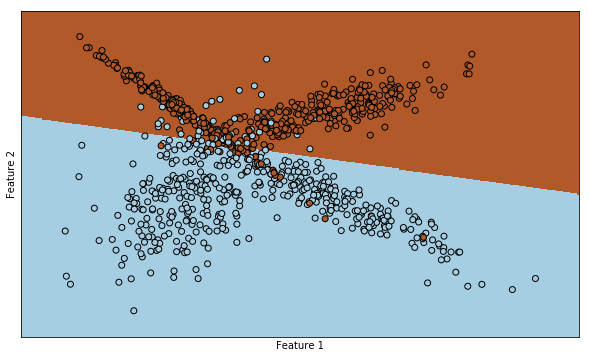

In [395]:
classifier = LogisticRegression(random_state=SEED)
plot_decision_boundary(scale(X), y, classifier)

As you can see a linear classifier tries to find a line that would separate two classes but a line cannot separate examples from two class so this model has very high bias.

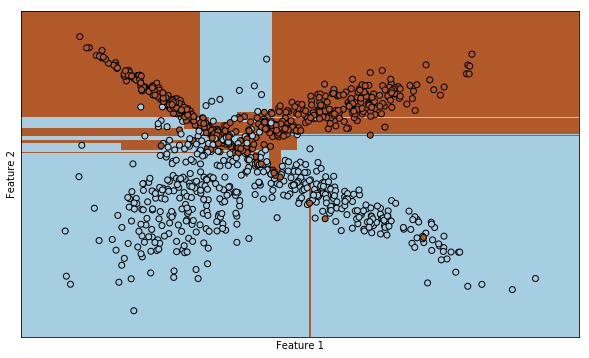

In [393]:
classifier = DecisionTreeClassifier(random_state=SEED)
plot_decision_boundary(scale(X), y, classifier)

Decision tree classifier doesn't suffer from this and is able to find complicated decision boundaries to separate the classes, but suffer from high variance because the performance of decision tree classifier trained on different set of training examples would be different.

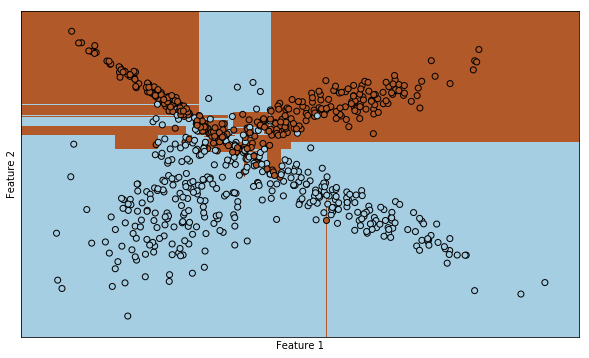

In [402]:
shuffled_indices = np.random.permutation(np.arange(len(X)))

Xtr_v1, ytr_v1   = X[shuffled_indices[:750]], y[shuffled_indices[:750]]

classifier = DecisionTreeClassifier(random_state=SEED)
plot_decision_boundary(Xtr_v1, ytr_v1, classifier)

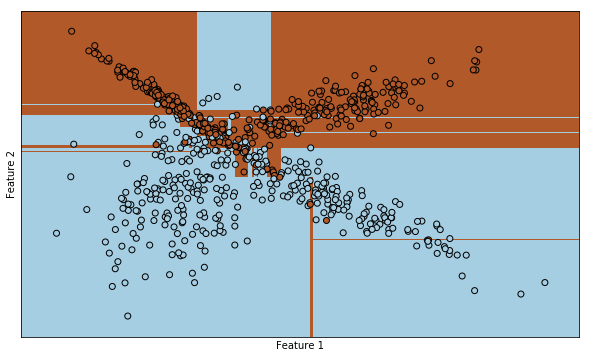

In [403]:
shuffled_indices = np.random.permutation(np.arange(len(X)))

Xtr_v2, ytr_v2   = X[shuffled_indices[:750]], y[shuffled_indices[:750]]

classifier = DecisionTreeClassifier(random_state=SEED)
plot_decision_boundary(Xtr_v2, ytr_v2, classifier)

Decision boundaries of above two decision tree classifiers are different which point to the claim that author is trying to make that decision tree classifiers trained on different training examples turn out to be different.

In [404]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

For decision tree classifiers there are many parameters that we need to tune like `depth`, `max_features` etc. to get the best classifier that doesn't overfit. We could use cross-validation to find out optimal values for these parameters.

Cross-Validation is a method of randomly dividing your training data into (say) 5 subsets, holding out each
one while training on the rest. But this is no panacea and using it to make too many parameter choices can cause overfitting as well.

Besides cross-validation we could use `regularization` which penalizes classifier more structure and favoring ones with less room to overfit.

We should be skeptical of claims that a particular technique `solves` the overfitting problem. It’s easy to avoid overfitting (variance) by falling into the opposite error of underfitting (bias). Simultaneously avoiding both requires learning a perfect classifier, and short of knowing it in advance there is no single technique that will always do best (__no free lunch__).

## Intuition fails in high dimensions. <a class="anchor" id="intuition"></a>

After overfitting biggest problem in Machine Learning is the problem of `curse of dimensionality`. It says generalization becomes exponentially harder as the dimensionality (number of features) of the examples grows, because a fixed-size training set covers a dwindling fraction of the input space.

Even with a moderate dimension of 100 and a huge training set of a trillion examples, the latter covers only a fraction of about $10^{−18}$ of the input space. This is what makes machine learning both necessary and hard.

Nearest neighbor has a problem even if all 100 features are relevant! This is because in high dimensions all examples look alike and all of the neighbors would be roughly at equal distances from the example in question, we can see this in action, we will create a synthetic dataset with 5000 examples and 150 relevant features and see the performance of KNN compared to the dataset with 5000 examples and only 10 relevant features.

In [429]:
X, y = make_classification(n_samples=5000, n_features=10, n_informative=10, n_redundant=0, random_state=SEED)

X_scaled = scale(X)
Xtr, ytr   = X_scaled[:750], y[:750]
Xval, yval = X_scaled[750:], y[750:]

knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski', n_jobs=-1)
knn.fit(Xtr, ytr)

knn_tr_preds  = knn.predict(Xtr)
knn_val_preds = knn.predict(Xval)

print('Accuracy on training set: {}'.format(accuracy_score(ytr, knn_tr_preds)))
print('Accuracy on validation set: {}'.format(accuracy_score(yval, knn_val_preds)))

Accuracy on training set: 0.9426666666666667
Accuracy on validation set: 0.9094117647058824


In [430]:
X, y = make_classification(n_samples=5000, n_features=150, n_informative=150, n_redundant=0, random_state=SEED)

X_scaled = scale(X)
Xtr, ytr   = X_scaled[:750], y[:750]
Xval, yval = X_scaled[750:], y[750:]

knn = KNeighborsClassifier(n_neighbors=3, metric='minkowski', n_jobs=-1)
knn.fit(Xtr, ytr)

knn_tr_preds  = knn.predict(Xtr)
knn_val_preds = knn.predict(Xval)

print('Accuracy on training set: {}'.format(accuracy_score(ytr, knn_tr_preds)))
print('Accuracy on validation set: {}'.format(accuracy_score(yval, knn_val_preds)))

Accuracy on training set: 0.952
Accuracy on validation set: 0.8675294117647059


The performance of the classifier went down even though all the features added were relevant to the target variable. It is easy to design a classifier when we are working in 2 or 3 dimensions but as we increase the dimensionality it becomes difficult to understand what exactly is going on. Naively, one might think that gathering
more features never hurts, since at worst they provide no new information about the class. But in fact their benefits may be outweighed by the curse of dimensionality.

Fortunately, there is an effect that partly counteracts the curse, which might be called the `blessing of non-uniformity.` In most applications examples are not spread uniformly throughout the instance space, but are concentrated on or near a lower-dimensional manifold.  For example, k-nearest neighbor works quite well for handwritten digit recognition even though images of digits have one dimension per pixel, because the space of digit images is much smaller than the space of all possible images.

## Theoretical gurantees are not what they seem. <a class="anchor" id="theoretical"></a>

Machine learning papers are full of theoretical guarantees. The most common type is a bound on the number of examples needed to ensure good generalization. What should you make of these guarantees ? First of all, it’s remarkable that they are even possible. The main role of theoretical guarantees in machine learning
is not as a criterion for practical decisions, but as a source of understanding and driving force for algorithm design. In this capacity, they are quite useful; indeed, the close interplay of theory and practice is one of the main reasons machine learning has made so much progress over the years. But `caveat emptor`: learning is a complex phenomenon, and just because a learner has a theoretical justification and works in practice doesn’t mean the former is the reason for the latter.

## Feature Engineering Is the Key <a class="anchor" id="feature"></a>

Some machine learning projects succeed and some fail. What makes the difference? Easily
the most important factor is the features used. If you have many independent features that each correlate well with the class, learning is easy. Machine learning is not a one-shot process of building a data set and running a learner, but rather an iterative process of running the learner, analyzing the results, modifying the data and/or the learner, and repeating.

One of the holy grail of Machine Learning is automatize feature generation process, currently how it is done is that we generate huge amount of features and then work out which ones work for the problem. But bear in mind that features that look irrelevant in isolation may be relevant in combination.

Let's take the example of XOR function of `k` input features, each of them by itself carry no information but when we combine these `k` features it suddenly becomes relevant.

In [431]:
X    = np.empty(shape=(1000, 2), dtype=np.uint8)
X[:, 0], X[:, 1] = np.random.randint(2, size=len(X)), np.random.randint(2, size=len(X))

y    = np.apply_along_axis(lambda x: reduce(np.logical_xor, x), axis=1, arr=X).astype(np.uint8)

X    = pd.DataFrame(X)
y    = pd.Series(y)

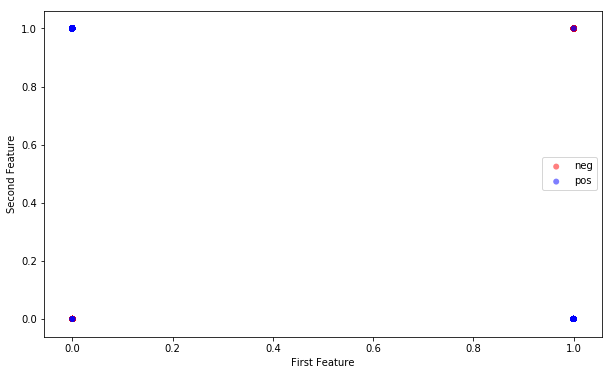

In [432]:
plot(X.values, y.values)

Red and Blue Labels are coinciding on top of each other, it is very difficult to find a linear separation between two classes.

In [434]:
pd.crosstab(X.iloc[:, 0], y)

col_0,0,1
0,,
0,262,246
1,237,255


In [435]:
pd.crosstab(X.iloc[:, 1], y)

col_0,0,1
1,,
0,263,257
1,236,244


These two features are not very relevant as we can see from the contingency tables that almost $(1/4)^{th}$ of total examples ( ~250 ) fall in each of the 4 buckets.

In [436]:
log = LogisticRegression(random_state=SEED)

Xtr, ytr   = X[:750], y[:750]
Xval, yval = X[750:], y[750:]

log.fit(Xtr, ytr)
log_preds = log.predict(Xval)

print('Accuracy on the holdout set: {}'.format(accuracy_score(yval, log_preds)))

Accuracy on the holdout set: 0.26


This is evident by the accuracy produced by the classifier trained on it. Now if we merge the two features $x_1$ and $x_2$ and create [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) of this variable we would find different results

In [437]:
X = pd.concat((X, pd.get_dummies(X.iloc[:, 0].astype(np.str) + '_' + X.iloc[:, 1].astype(np.str))), axis=1)

In [438]:
log = LogisticRegression(random_state=SEED)

Xtr, ytr   = X[:750], y[:750]
Xval, yval = X[750:], y[750:]

log.fit(Xtr, ytr)
log_preds = log.predict(Xval)

print('Accuracy on the holdout set: {}'.format(accuracy_score(yval, log_preds)))

Accuracy on the holdout set: 1.0


By just adding this combination we were able to learn perfect classifier, that is why the author emphasizes that feature engineering is the key.

## More data beats cleverer algorithm <a class="anchor" id="more-data"></a>

Suppose you’ve constructed the best set of features you can, but the classifiers you’re getting are still not accurate enough. What can you do now? There are two main choices:
- design a better learning algorithm
- gather more data

ML researchers are mainly concerned with the former but pragmatically the quickest path to success it getting more data. As a rule of thumb, a dumb algorithm with lots and lots of data beats a clever one with modest amounts of it.

## Learn many models not one <a class="anchor" id="many-models"></a>

Early on everyone had their favorite learners with some `apriori` reasons to believe in its superiority. Most of the effort was then spent to try many variations of it and select the best one.

Then systematic empirical comparisons showed that the best learner varies from application to application, and systems containing many different learners started to appear. Effort now went into trying
many variations of many learners, and still selecting just the best one. But then researchers noticed that, if instead of selecting the best variation found, we combine many variations, the results are better—often much better—and at little extra effort for the user.

Thus creating `model ensembles` became the standard routine. We will demonstrate a basic ensemble techinque of `averaging` which combines results from various different classifiers.

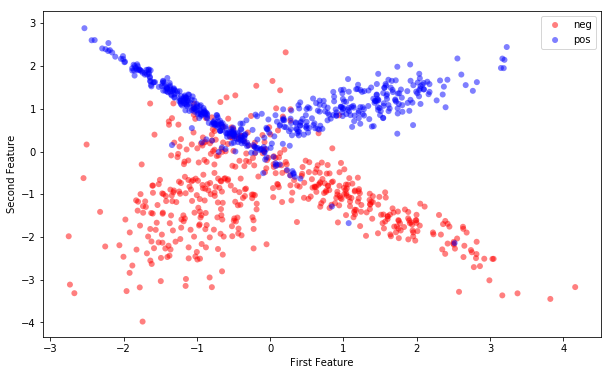

In [439]:
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, random_state=SEED)
plot(X, y)

### Logistic Regression

In [444]:
classifier = LogisticRegression(random_state=SEED)

X_scaled = scale(X)
Xtr, ytr   = X_scaled[:750], y[:750]
Xval, yval = X_scaled[750:], y[750:]

classifier.fit(Xtr, ytr)
yval_preds = classifier.predict(Xval)

print('Accuracy on the validation set: {}'.format(accuracy_score(yval, yval_preds)))

Accuracy on the validation set: 0.892


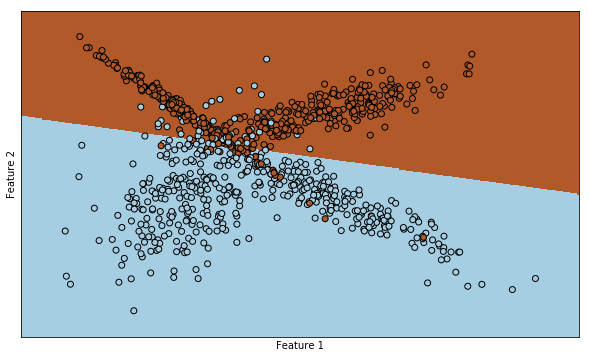

In [445]:
plot_decision_boundary(X_scaled, y, classifier)

### Random Forest Classifier

In [446]:
classifier = RandomForestClassifier(n_estimators=50, random_state=SEED)

X_scaled = scale(X)
Xtr, ytr   = X_scaled[:750], y[:750]
Xval, yval = X_scaled[750:], y[750:]

classifier.fit(Xtr, ytr)
yval_preds = classifier.predict(Xval)

print('Accuracy on the validation set: {}'.format(accuracy_score(yval, yval_preds)))

Accuracy on the validation set: 0.916


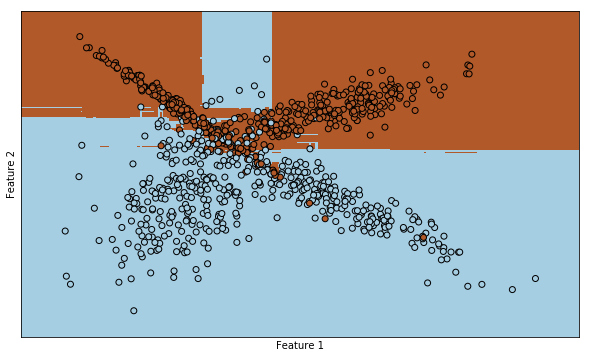

In [447]:
plot_decision_boundary(scale(X), y, classifier)

## SVC ( Support Vector Machines )

In [448]:
classifier = SVC(random_state=SEED)

X_scaled = scale(X)
Xtr, ytr   = X_scaled[:750], y[:750]
Xval, yval = X_scaled[750:], y[750:]

classifier.fit(Xtr, ytr)
yval_preds = classifier.predict(Xval)

print('Accuracy on the validation set: {}'.format(accuracy_score(yval, yval_preds)))

Accuracy on the validation set: 0.908


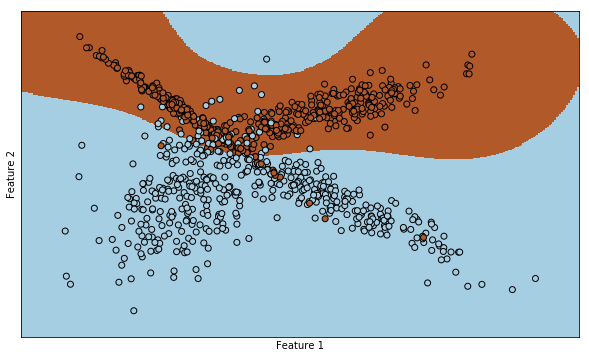

In [449]:
plot_decision_boundary(scale(X), y, classifier)

As we can see that the three classifiers were able to separate out classes by drawing out different decision boundaries, we know that it is very difficult to separate out classes using a linear boundary so let's try to merge Random Forest Classifier with Support Vector Machine to see if it would give boost to accuracy or not.

In [470]:
X_scaled = scale(X)
Xtr, ytr   = X_scaled[:750], y[:750]
Xval, yval = X_scaled[750:], y[750:]


classifier = VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, random_state=SEED)), 
        ('svc', SVC(random_state=SEED))], 
                       voting='hard')

classifier.fit(Xtr, ytr)
yval_preds = classifier.predict(Xval)

print('Accuracy on the validation set: {}'.format(accuracy_score(yval, yval_preds)))

Accuracy on the validation set: 0.924


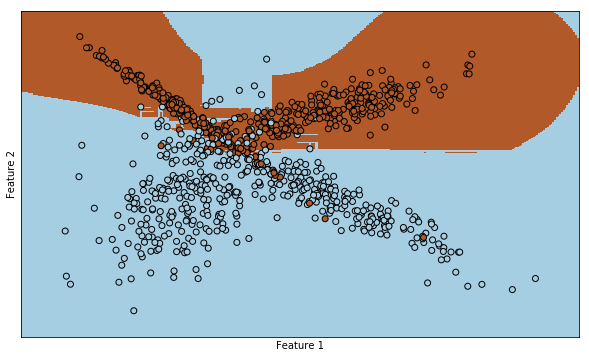

In [471]:
plot_decision_boundary(scale(X), y, classifier)

Clearly by ensembling these two models we were able to push the accuracy to **0.924**. Decision boundary has also become a bit more smooth.

## Simplicity does not imply accuracy <a class="anchor" id="simplicity"></a>

`Occam’s razor` famously states that entities should not be multiplied beyond necessity. In machine learning, this is often taken to mean that, given two classifiers with the same training error, the simpler of the two will likely have the lowest test error. Purported proofs of this claim appear regularly in the literature, but in fact there are many counterexamples to it, and the “no free lunch” theorems imply it cannot be true.

We saw one counter-example in the previous section: model ensembles. Simpler hypotheses should be preferred because
simplicity is a virtue in its own right, not because of a hypothetical connection with accuracy.

## Representable does not imply learnable <a class="anchor" id="representable"></a>

Just because a function can be represented does not mean it can be learned. For example, standard decision tree learners cannot learn trees with more leaves than there are training examples.

If the hypothesis space has many local optima of the evaluation function, as is often the case, the learner may not find the true function even if it is representable. Given finite data, time and memory, standard learners can learn only a tiny subset of all possible functions, and these subsets are different for learners
with different representations so it pays to try different learners.

## Correlation does not imply causation <a class="anchor" id="correlation-causation"></a>

The point that correlation does not imply causation is made so often that it is perhaps not worth belaboring. Learners of the kind that we have been discussing can only learn correlations but their results are often treated as causal relations.

If we find that beer and diapers are often bought together at the supermarket, then perhaps putting beer next to the diaper section will increase sales.

Machine Learning is often applied to `observational data` where the target variable are under control as opposed to `experimental data`. Correlation is a sign of a potential causal connection, and we can use it as a guide to further investigation.

Whether or not we call them `causal,` we would like to predict the effects of our actions, not just `correlations` between observable variables.

## Conclusion <a class="anchor" id="conclusion"></a>

This paper tried to bring to light certain pitfalls and ideas that every machine learning practitioner should keep in mind when designing successul machine learning systems.